<a href="https://colab.research.google.com/github/katterine2558/ods-semantic-hub/blob/main/ods_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUCIÓN MICROPROYECTO 2

Por: *Leonardo Almanza y Katerine Arias*

## 1. Importar librerías
En esta etapa inicial se realiza la importación de las librerías esenciales para desarrollar una solución automatizada de clasificación de textos según los 17 Objetivos de Desarrollo Sostenible (ODS). Se incluyen herramientas fundamentales para manipulación y análisis de datos (Pandas, NumPy), procesamiento de lenguaje natural (NLTK, word_tokenize, stopwords, PorterStemmer), extracción de características textuales (CountVectorizer, TfidfVectorizer), implementación de algoritmos de machine learning supervisado (Naive Bayes, Regresión Logística) y  técnicas de reducción de dimensionalidad (PCA, TruncatedSVD). Estas herramientas permiten transformar textos  en representaciones vectoriales mediante el esquema de bolsa de palabras (BOW) con pesado TF-IDF, aplicar técnicas de reducción de dimensionalidad para manejar la alta dimensionalidad del espacio de entrada, y construir modelos de clasificación automática.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# NLTK para procesamiento de texto
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    print("Recursos NLTK descargados exitosamente")
except:
    print("Algunos recursos de NLTK no se pudieron descargar")

print("Librerías importadas exitosamente")

Recursos NLTK descargados exitosamente
Librerías importadas exitosamente


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Carga y Exploración de Datos

=== INFORMACIÓN DEL DATASET ===
Forma del dataset: (9656, 2)
Columnas: ['textos', 'ODS']

Primeras 5 filas:
                                              textos  ODS
0  "Aprendizaje" y "educación" se consideran sinó...    4
1  No dejar clara la naturaleza de estos riesgos ...    6
2  Como resultado, un mayor y mejorado acceso al ...   13
3  Con el Congreso firmemente en control de la ju...   16
4  Luego, dos secciones finales analizan las impl...    5

Distribución de clases (ODS):
ODS
1      505
2      369
3      894
4     1025
5     1070
6      695
7      787
8      446
9      343
10     352
11     607
12     312
13     464
14     377
15     330
16    1080
Name: count, dtype: int64

Valores nulos:
textos    0
ODS       0
dtype: int64


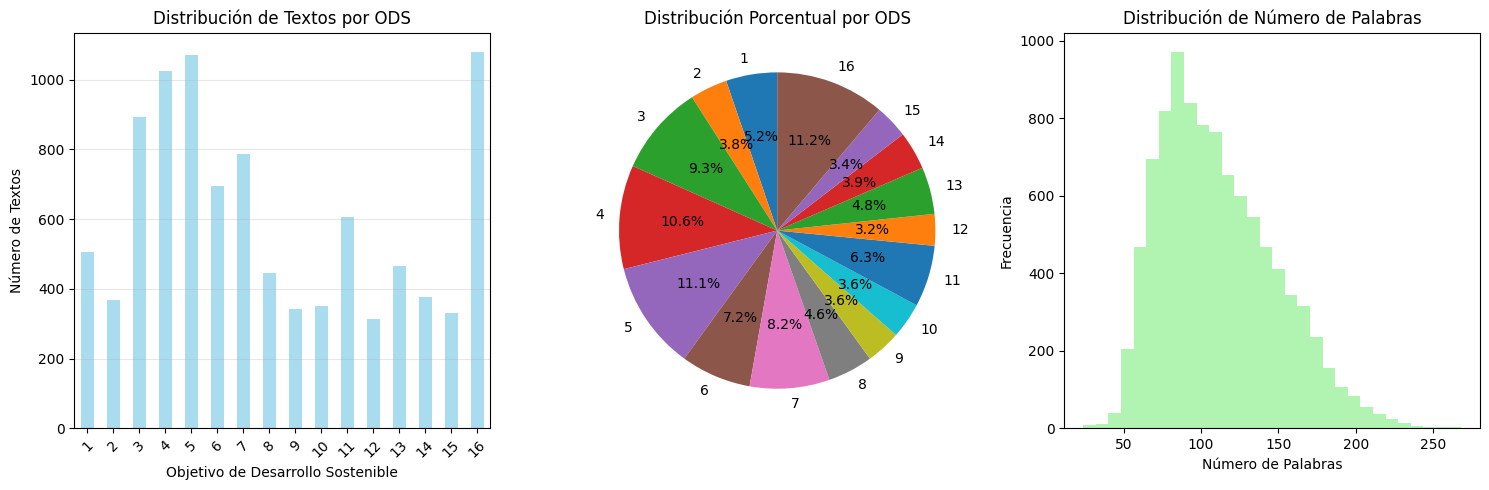


=== ESTADÍSTICAS DE TEXTO ===
Longitud promedio de caracteres: 709.0
Longitud promedio de palabras: 111.0
Texto más corto: 143 caracteres
Texto más largo: 1977 caracteres


In [3]:
# Cargar datos
df = pd.read_excel('train_textos.xlsx')

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Forma del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())

print(f"\nDistribución de clases (ODS):")
ods_counts = df['ODS'].value_counts().sort_index()
print(ods_counts)

# Verificar valores nulos
print(f"\nValores nulos:")
print(df.isnull().sum())

# Visualización básica con matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ods_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribución de Textos por ODS')
plt.xlabel('Objetivo de Desarrollo Sostenible')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
plt.pie(ods_counts.values, labels=ods_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución Porcentual por ODS')

# Estadísticas básicas de texto
df['longitud_texto'] = df['textos'].str.len()
df['num_palabras'] = df['textos'].str.split().str.len()

plt.subplot(1, 3, 3)
plt.hist(df['num_palabras'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribución de Número de Palabras')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f"\n=== ESTADÍSTICAS DE TEXTO ===")
print(f"Longitud promedio de caracteres: {df['longitud_texto'].mean():.1f}")
print(f"Longitud promedio de palabras: {df['num_palabras'].mean():.1f}")
print(f"Texto más corto: {df['longitud_texto'].min()} caracteres")
print(f"Texto más largo: {df['longitud_texto'].max()} caracteres")

Se encuentran 16 ODS

## 3. Preprocesamiento de Textos
 - **Limpieza**: Normalización de texto para reducir ruido
 - **Tokenización**: División en unidades de análisis
 - **Eliminación de stopwords**: Remoción de palabras sin valor semántico
 - **Stemming**: Reducción a raíces para agrupar variantes

### 3.1 Procesador de texto

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado para preprocesamiento de texto
    Integrable en pipelines de sklearn
    """

    def __init__(self, language='spanish'):
        self.language = language
        try:
            self.stop_words = set(stopwords.words(language))
        except:
            self.stop_words = set(stopwords.words('english'))
            print(f"Usando stopwords en inglés como respaldo")

        self.stemmer = PorterStemmer()

    def fit(self, X, y=None):
        # No hay parámetros que ajustar
        return self

    def transform(self, X):
        """
        Aplica preprocesamiento completo a una serie de textos
        """
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        """
        Función de preprocesamiento integrada en el transformador
        """
        if pd.isna(text):
            return ""

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar caracteres especiales, conservar solo letras y espacios
        text = re.sub(r'[^a-záéíóúñü\s]', ' ', text)

        # Eliminar espacios múltiples
        text = re.sub(r'\s+', ' ', text)

        # Tokenización
        try:
            tokens = word_tokenize(text, language=self.language)
        except:
            tokens = word_tokenize(text)

        # Eliminar stopwords, palabras cortas y aplicar stemming
        tokens = [self.stemmer.stem(word) for word in tokens
                  if word not in self.stop_words and len(word) > 2]

        return ' '.join(tokens)


In [5]:
# Instanciar el preprocesador
text_preprocessor = TextPreprocessor(language='spanish')

3.2 DEMOSTRACIÓN DEL TRANSFORMADOR DE PREPROCESAMIENTO

In [6]:

print("\n=== EJEMPLOS DE PREPROCESAMIENTO CON TRANSFORMADOR ===")

# Seleccionar algunos textos para demostrar
textos_ejemplo = df['textos'].head(3)

print("Aplicando transformador a textos de ejemplo...")
textos_procesados = text_preprocessor.transform(textos_ejemplo)
for i in range(len(textos_ejemplo)):
    print(f"\nEjemplo {i+1}:")
    print(f"Original: {textos_ejemplo.iloc[i][:200]}...")
    print(f"Procesado: {textos_procesados.iloc[i][:200]}...")


=== EJEMPLOS DE PREPROCESAMIENTO CON TRANSFORMADOR ===
Aplicando transformador a textos de ejemplo...

Ejemplo 1:
Original: "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formació...
Procesado: aprendizaj educación consideran sinónimo escolarización formal organizacion auxiliar editorial educación junta examinadora organizacion formación docent consideran extension acuerdo establecido gobier...

Ejemplo 2:
Original: No dejar clara la naturaleza de estos riesgos puede dar lugar a un exceso de inversión en empresas dependientes del agua y a peticiones de compensación cuando haya que reducir los derechos para evitar...
Procesado: dejar clara naturaleza riesgo pued dar lugar exceso inversión empresa dependient agua peticion compensación reducir derecho evitar compromet calidad agua resultado medioambiental ejemplo fundament evi...

Ejemplo 3:
Ori

### 3.3 Aplicar transformador a todos los textos


In [7]:
df['texto_procesado_transformer'] = text_preprocessor.transform(df['textos'])

# Verificar textos vacíos después del procesamiento
textos_vacios = (df['texto_procesado_transformer'].str.len() == 0).sum()
print(f"Textos vacíos después del procesamiento: {textos_vacios}")

if textos_vacios > 0:
    print(f"Eliminando {textos_vacios} textos vacíos...")
    df = df[df['texto_procesado_transformer'].str.len() > 0].reset_index(drop=True)
    print(f"Dataset después de limpieza: {df.shape}")
else:
    print("✅ Todos los textos fueron procesados correctamente")

Textos vacíos después del procesamiento: 0
✅ Todos los textos fueron procesados correctamente


### 3.4 Comparación visual



=== ESTADÍSTICAS DEL PREPROCESAMIENTO ===
Longitud promedio después de procesamiento: 472.9 caracteres
Palabras promedio después de procesamiento: 56.5
Reducción de longitud: 33.3%


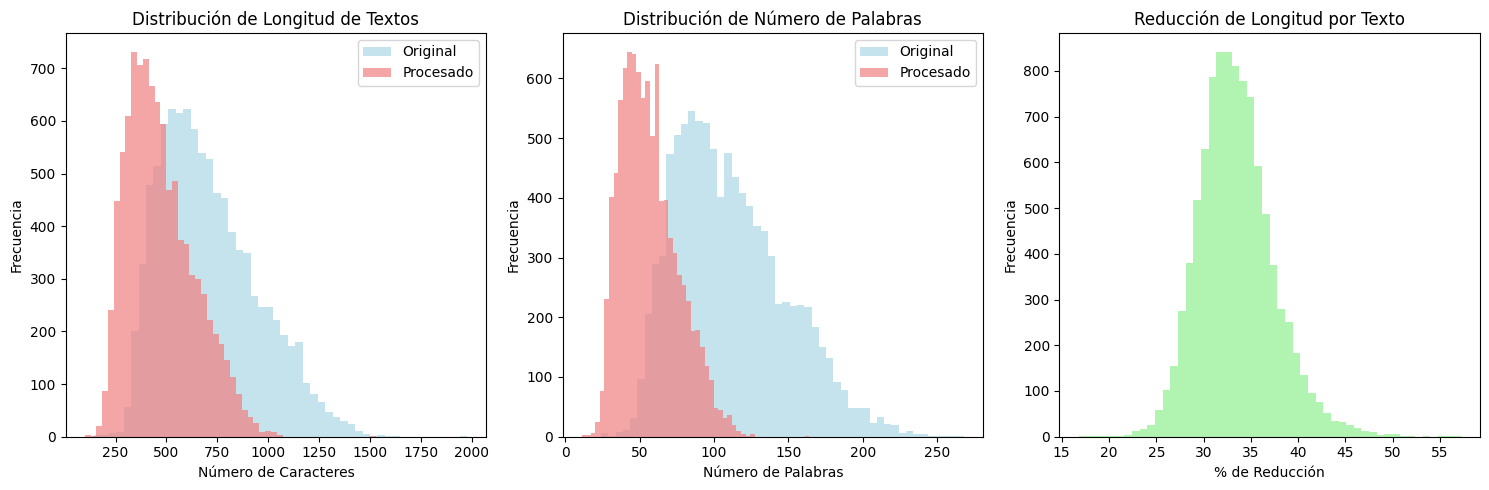

In [8]:

# Estadísticas del preprocesamiento
print(f"\n=== ESTADÍSTICAS DEL PREPROCESAMIENTO ===")
df['longitud_procesado'] = df['texto_procesado_transformer'].str.len()
df['num_palabras_procesado'] = df['texto_procesado_transformer'].str.split().str.len()

print(f"Longitud promedio después de procesamiento: {df['longitud_procesado'].mean():.1f} caracteres")
print(f"Palabras promedio después de procesamiento: {df['num_palabras_procesado'].mean():.1f}")
print(f"Reducción de longitud: {((df['longitud_texto'].mean() - df['longitud_procesado'].mean()) / df['longitud_texto'].mean() * 100):.1f}%")

# Comparación visual
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['longitud_texto'], bins=50, alpha=0.7, color='lightblue', label='Original')
plt.hist(df['longitud_procesado'], bins=50, alpha=0.7, color='lightcoral', label='Procesado')
plt.title('Distribución de Longitud de Textos')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(df['num_palabras'], bins=50, alpha=0.7, color='lightblue', label='Original')
plt.hist(df['num_palabras_procesado'], bins=50, alpha=0.7, color='lightcoral', label='Procesado')
plt.title('Distribución de Número de Palabras')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1, 3, 3)
reduccion_por_texto = (df['longitud_texto'] - df['longitud_procesado']) / df['longitud_texto'] * 100
plt.hist(reduccion_por_texto, bins=50, alpha=0.7, color='lightgreen')
plt.title('Reducción de Longitud por Texto')
plt.xlabel('% de Reducción')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

 ## 4. División de Datos y Configuración de Vectorización

### 4.1 Separación de variable objetivo

Se separala variable objetivo de los textos, que se convertirán en las variables descriptoras:

In [20]:
# División de datos
X = df['textos']
y = df['ODS']

In [13]:
# División estratificada para mantener proporciones de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
# Definir parámetros
tfidf_params = {
    'max_features': 5000,
    'min_df': 2,
    'max_df': 0.95,
    'ngram_range': (1, 2),
    'sublinear_tf': True
}

n_components = 500
pipelines_completos = {}

print(f"Parámetros de configuración:")
print(f"- TF-IDF features: {tfidf_params['max_features']}")
print(f"- Componentes de reducción: {n_components}")
print(f"- Clasificador: Regresión Logística")

Parámetros de configuración:
- TF-IDF features: 5000
- Componentes de reducción: 500
- Clasificador: Regresión Logística


### 4.2.1 Pipeline 1: Preprocesamiento → TF-IDF → TruncatedSVD → Regresión Logística


In [26]:
# Pipeline 1: Preprocesamiento → TF-IDF → TruncatedSVD → Regresión Logística
try:
    pipeline_svd_completo = Pipeline([
        ('preprocessor', text_preprocessor),
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('dimensionality_reduction', TruncatedSVD(n_components=n_components, random_state=42)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    pipelines_completos['TruncatedSVD'] = pipeline_svd_completo

except Exception as e:
    print(f"   ✗ Error creando pipeline SVD: {e}")

### 4.2.2 Pipeline 2: Preprocesamiento → TF-IDF → PCA → Regresión Logística  



In [28]:
# Pipeline 2: Preprocesamiento → TF-IDF → PCA → Regresión Logística
try:
  # PCA requiere formato denso (todos los valores explícitos):
  # Sparse → Dense conversion necesaria
    pipeline_pca_completo = Pipeline([
        ('preprocessor', text_preprocessor),
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ('dimensionality_reduction', PCA(n_components=n_components, random_state=42)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    pipelines_completos['PCA'] = pipeline_pca_completo

except Exception as e:
    print(f"   ✗ Error creando pipeline PCA: {e}")

###  **Entrenar y evaluar pipelines completos**


In [30]:
print("=== ENTRENAMIENTO DE PIPELINES INTEGRADOS ===")
print("Entrenando pipelines que incluyen preparación + reducción + clasificación")

resultados_pipelines = {}

# Entrenar cada pipeline completo con datos RAW (texto original)
for nombre, pipeline in pipelines_completos.items():
    print(f"\n🔄 Entrenando pipeline: {nombre}")
    print("   Input: Texto crudo (sin preprocesamiento previo)")

    try:
        # Entrenar pipeline completo con texto original
        pipeline.fit(df['textos'].iloc[X_train.index], y_train)

        # Evaluar con texto original del conjunto de prueba
        y_pred = pipeline.predict(df['textos'].iloc[X_test.index])
        accuracy = accuracy_score(y_test, y_pred)

        resultados_pipelines[nombre] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'n_steps': len(pipeline.steps)
        }

        print(f"   ✅ Entrenamiento exitoso")
        print(f"   📊 Accuracy: {accuracy:.4f}")
        print(f"   🔧 Pasos del pipeline: {len(pipeline.steps)}")

        # Mostrar información detallada del pipeline
        print("   📋 Pasos ejecutados:")
        for i, (step_name, transformer) in enumerate(pipeline.steps, 1):
            print(f"      {i}. {step_name}: {transformer.__class__.__name__}")

    except Exception as e:
        print(f"   ❌ Error: {e}")
        resultados_pipelines[nombre] = {
            'pipeline': None,
            'accuracy': 0.0,
            'n_steps': 0
        }

=== ENTRENAMIENTO DE PIPELINES INTEGRADOS ===
Entrenando pipelines que incluyen preparación + reducción + clasificación

🔄 Entrenando pipeline: TruncatedSVD
   Input: Texto crudo (sin preprocesamiento previo)
   ✅ Entrenamiento exitoso
   📊 Accuracy: 0.8784
   🔧 Pasos del pipeline: 4
   📋 Pasos ejecutados:
      1. preprocessor: TextPreprocessor
      2. tfidf: TfidfVectorizer
      3. dimensionality_reduction: TruncatedSVD
      4. classifier: LogisticRegression

🔄 Entrenando pipeline: PCA
   Input: Texto crudo (sin preprocesamiento previo)
   ✅ Entrenamiento exitoso
   📊 Accuracy: 0.8789
   🔧 Pasos del pipeline: 5
   📋 Pasos ejecutados:
      1. preprocessor: TextPreprocessor
      2. tfidf: TfidfVectorizer
      3. densify: FunctionTransformer
      4. dimensionality_reduction: PCA
      5. classifier: LogisticRegression


In [31]:
# COMPARACIÓN DE PIPELINES INTEGRADOS
print(f"\n{'='*80}")
print("COMPARACIÓN DE PIPELINES INTEGRADOS COMPLETOS")
print(f"{'='*80}")

# Ordenar por accuracy
pipelines_ordenados = sorted(resultados_pipelines.items(),
                            key=lambda x: x[1]['accuracy'], reverse=True)

print(f"{'Rank':<4} {'Pipeline Integrado':<20} {'Accuracy':<10} {'N° Pasos':<10}")
print("-" * 48)

for i, (nombre, info) in enumerate(pipelines_ordenados):
    print(f"{i+1:<4} {nombre:<20} {info['accuracy']:<10.4f} {info['n_steps']:<10}")

# Seleccionar el mejor pipeline
mejor_pipeline_info = pipelines_ordenados[0]
mejor_nombre = mejor_pipeline_info[0]
mejor_info = mejor_pipeline_info[1]
mejor_pipeline = mejor_info['pipeline']

print(f"\n🏆 MEJOR PIPELINE INTEGRADO SELECCIONADO:")
print(f"   Pipeline: {mejor_nombre}")
print(f"   Accuracy: {mejor_info['accuracy']:.4f}")
print(f"   Pasos integrados: {mejor_info['n_steps']}")

# Establecer como modelo final
modelo_final = mejor_pipeline
accuracy_final = mejor_info['accuracy']

print(f"\n✅ PIPELINE INTEGRADO ESTABLECIDO COMO MODELO FINAL")
print(f"   Cumple criterio: Preparación + Reducción + Clasificación en un solo pipeline")


COMPARACIÓN DE PIPELINES INTEGRADOS COMPLETOS
Rank Pipeline Integrado   Accuracy   N° Pasos  
------------------------------------------------
1    PCA                  0.8789     5         
2    TruncatedSVD         0.8784     4         

🏆 MEJOR PIPELINE INTEGRADO SELECCIONADO:
   Pipeline: PCA
   Accuracy: 0.8789
   Pasos integrados: 5

✅ PIPELINE INTEGRADO ESTABLECIDO COMO MODELO FINAL
   Cumple criterio: Preparación + Reducción + Clasificación en un solo pipeline
